In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report


In [ ]:
data = pd.read_json('/content/Sarcasm_Headlines_Dataset.json' , lines = True)
data

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0
...,...,...,...
26704,https://www.huffingtonpost.com/entry/american-...,american politics in moral free-fall,0
26705,https://www.huffingtonpost.com/entry/americas-...,america's best 20 hikes,0
26706,https://www.huffingtonpost.com/entry/reparatio...,reparations and obama,0
26707,https://www.huffingtonpost.com/entry/israeli-b...,israeli ban targeting boycott supporters raise...,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_link  26709 non-null  object
 1   headline      26709 non-null  object
 2   is_sarcastic  26709 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 626.1+ KB


## PreProcessing

In [ ]:
def get_sequences(texts, tokenizer, train=True, max_seq_length=None):
    sequences = tokenizer.texts_to_sequences(texts)
    
    if train == True:
        max_seq_length = np.max(list(map(len, sequences)))
    
    sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_seq_length, padding='post')
    
    return sequences

In [ ]:
def preprocess_inputs(df):
  df = df.copy()
  
  #droppin article_link
  df = df.drop('article_link', axis = 1)

  # split X and y
  y = df['is_sarcastic']
  X = df['headline']

  # train test split
  X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, shuffle = True, random_state = 1) 

  # create and fit tokenizer
  tokenizer = tf.keras.preprocessing.text.Tokenizer()
  tokenizer.fit_on_texts(X_train)
  print('vocab length', len(tokenizer.word_index) + 1)

  # Get sequence data
  X_train = get_sequences(texts=X_train, tokenizer=tokenizer, train=True)
  X_test = get_sequences(texts=X_test, tokenizer=tokenizer, train=False, max_seq_length=X_train.shape[1])

  print ('sequence length' , X_train.shape[1])

  return X_train, y_train, X_test, y_test


In [ ]:
X_train, y_train, X_test, y_test = preprocess_inputs(data)

vocab length 24846
sequence length 40


In [ ]:
X_train

21906       don king enjoys grandilomentitudinous sandwich
24781    vital info on iraqi chemical weapons provided ...
22552    hacker releases new 'orange is the new black' ...
17857                      how boredom can lead to failure
20032                                mind the (gender) gap
                               ...                        
10955    5 ways to outsmart the supermarket and lose we...
17289    reflecting on the aids epidemic this gay men's...
5192     arianna joins payoff to 'reshape' financial se...
12172    rashida jones pays homage to the '90s with 'fl...
235      how to rebuild your credit after bankruptcy --...
Name: headline, Length: 18696, dtype: object

In [ ]:
y_train

21906    1
24781    1
22552    0
17857    0
20032    0
        ..
10955    0
17289    0
5192     0
12172    0
235      0
Name: is_sarcastic, Length: 18696, dtype: int64

In [ ]:
y_train.value_counts()

0    10499
1     8197
Name: is_sarcastic, dtype: int64

# Training

In [ ]:
inputs = tf.keras.Input(shape=(40,))
x = tf.keras.layers.Embedding(
    input_dim=24846,
    output_dim=64
)(inputs)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation = 'relu')(x)
x = tf.keras.layers.Dense(128, activation = 'relu')(x)
outputs = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)

model = tf.keras.Model(inputs = inputs, outputs = outputs)

model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics=[
             'accuracy',
             tf.keras.metrics.AUC(name = 'auc')
    ]
)
print (model.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 40)]              0         
                                                                 
 embedding_10 (Embedding)    (None, 40, 64)            1590144   
                                                                 
 flatten_8 (Flatten)         (None, 2560)              0         
                                                                 
 dense_14 (Dense)            (None, 128)               327808    
                                                                 
 dense_15 (Dense)            (None, 128)               16512     
                                                                 
 dense_16 (Dense)            (None, 1)                 129       
                                                                 
Total params: 1,934,593
Trainable params: 1,934,593
Non-tra

In [ ]:
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=100,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(
                   monitor = 'val_loss',
                   patience=3,
                   restore_best_weights=True
               )
    ]
)

Epoch 1/100
468/468 [==============================] - 18s 34ms/step - loss: 0.4089 - accuracy: 0.7979 - auc: 0.8900 - val_loss: 0.3194 - val_accuracy: 0.8644 - val_auc: 0.9374
Epoch 2/100
468/468 [==============================] - 16s 33ms/step - loss: 0.0858 - accuracy: 0.9694 - auc: 0.9948 - val_loss: 0.4502 - val_accuracy: 0.8465 - val_auc: 0.9205
Epoch 3/100
468/468 [==============================] - 15s 33ms/step - loss: 0.0076 - accuracy: 0.9980 - auc: 0.9998 - val_loss: 0.5640 - val_accuracy: 0.8393 - val_auc: 0.9166
Epoch 4/100
468/468 [==============================] - 15s 33ms/step - loss: 0.0013 - accuracy: 0.9995 - auc: 1.0000 - val_loss: 0.6369 - val_accuracy: 0.8465 - val_auc: 0.9125


Accuracy: 85.84%
     AUC: 0.93774


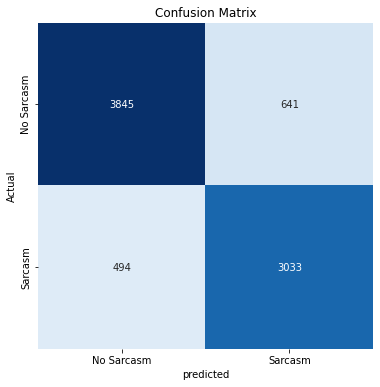

Classification Report:
------------------
               precision    recall  f1-score   support

  No Sarcasm       0.89      0.86      0.87      4486
     Sarcasm       0.83      0.86      0.84      3527

    accuracy                           0.86      8013
   macro avg       0.86      0.86      0.86      8013
weighted avg       0.86      0.86      0.86      8013



In [ ]:
results = model.evaluate(X_test, y_test, verbose=0)

print("Accuracy: {:.2f}%".format(results[1] * 100))
print("     AUC: {:.5f}".format(results[2]))

y_pred = np.squeeze(model.predict(X_test)>=0.5).astype(int)
cm = confusion_matrix(y_test, y_pred, labels=[0,1])
clr = classification_report(y_test, y_pred, labels=[0,1], target_names = ["No Sarcasm", "Sarcasm"])

plt.figure(figsize = (6,6))
sns.heatmap(cm, annot=True, fmt='g', vmin = 0, cmap = 'Blues', cbar = False)
plt.xticks(ticks = [0.5,1.5], labels=["No Sarcasm", "Sarcasm"])
plt.yticks(ticks = [0.5,1.5], labels=["No Sarcasm", "Sarcasm"])
plt.xlabel('predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.show()
print("Classification Report:\n------------------\n", clr)